In [14]:
import django, sys, os, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *

from sklearn.svm import SVC
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier


In [24]:
columns = [
    'id',
    'UT_id',
    'authors',
    'content',
    'first_author',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

Index(['index', 'PY', 'UT_id', 'authors', 'citation_objects', 'content',
       'date', 'dtype', 'duplicated', 'first_author', 'fulltext', 'id',
       'journal_id', 'rated', 'relevant', 'scopus', 'source', 'tilength',
       'title', 'uploaded', 'uploader_id', 'url', 'wos', 'ymentions'],
      dtype='object')

In [ ]:
q = Query.objects.get(pk=2801)
ratings = list(Doc.objects.filter(query=q,content__iregex='\w').values(*columns))
for r in ratings:
    d = Doc.objects.get(pk=r['id'])
    dos = DocOwnership.objects.filter(query=q,doc=d,relevant__gt=0)
    if dos.count() == 1:
        r['relevant'] = dos.first().relevant
        r['rated'] = dos.first().date
    elif dos.count() > 1:
        if dos.filter(relevant=1).count()>0:
            r['relevant'] = 1
            r['rated'] = dos.first().date
        else:
            r['relevant'] = dos.order_by('relevant').first().relevant
            r['rated'] = dos.first().date
    else:
        r['relevant'] = 8
        r['rated'] = ""
        
df = pd.DataFrame.from_dict(ratings)

df = df[df['relevant'].isin([1,2])]

df['relevant'][df['relevant']==2] = 0

df.head()


In [3]:
df = df.reset_index()
df.to_csv('docs.csv')

0
1


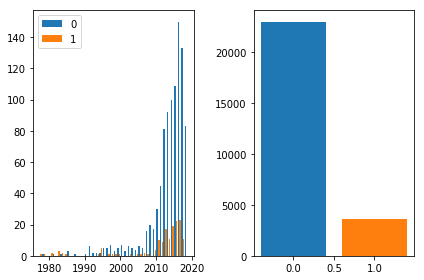

In [4]:
i = 0
fig, axs = plt.subplots(1,2)

for name, group in df.groupby('relevant'):
    print(name)
    bypy = group.groupby('PY').size()
    if i==1:
        offset=-.25
    else:
        offset=.25
    axs[0].bar(bypy.index+offset,bypy,width=0.4,label=name)
    
    axs[0].legend()
    axs[1].bar(i,group.size)
    i+=1
    
fig.tight_layout()

In [5]:
import re, string
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

re_tok = re.compile('([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

import string

from nltk import wordpunct_tokenize
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords as sw
punct = set(string.punctuation)
from nltk.corpus import wordnet as wn

stopwords = set(sw.words('english'))

def lemmatize(token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return WordNetLemmatizer().lemmatize(token, tag)

def tokenize(X):
    for sent in sent_tokenize(X):
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            token = token.lower().strip()
            if token in stopwords:
                continue
            if all(char in punct for char in token):
                continue
            if len(token) < 2:
                continue
            if all(char in string.digits for char in token):
                continue
            lemma = lemmatize(token,tag)
            yield lemma


vec = TfidfVectorizer(ngram_range=(1,4),
               min_df=3, max_df=0.8, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1,stop_words="english")

data_term_doc = vec.fit_transform(df['content'])

vocab = vec.get_feature_names()
vocab[1055:1065]

['calculations',
 'calculus',
 'calibrated',
 'calibration',
 'california',
 'called',
 'calls',
 'camera',
 'campaign',
 'campaigns']

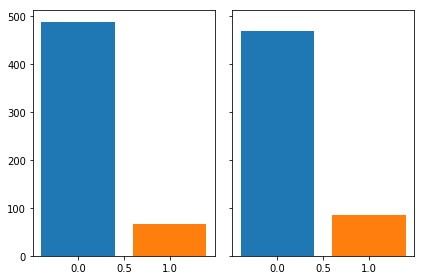

In [6]:
train = df.sample(frac=0.5)
test = df[~df['id'].isin(train['id'])]

tfidf_train = data_term_doc[train.index,:]
tfidf_test = data_term_doc[test.index,:]

y_train = np.array(train['relevant'])
y_test = np.array(test['relevant'])

y = np.array(df['relevant'])

i = 0
fig, axs = plt.subplots(1,2,sharey=True)

for name, group in train.groupby('relevant'): 
    axs[0].bar(i,group['id'].size)
    i+=1
i=0
for name, group in test.groupby('relevant'): 
    axs[1].bar(i,group['id'].size)
    i+=1
    
fig.tight_layout()


In [16]:
def plot_model_accuracy(model,x_test,y_test,ax,threshold=0.1,inv=False):
    y_prob = model.predict_proba(x_test)
    prob_y_true = y_prob[:,1]
    prob_y_false = y_prob[:,0]
    order = np.argsort(prob_y_true)
    ordered_prob = prob_y_true[order]
    prob_y_false = prob_y_false[order]
    cutoff = np.argmax(ordered_prob>threshold)

    y_predicted = np.where(prob_y_true > threshold,1,0)

    from sklearn.metrics import precision_score, recall_score
    p = precision_score(y_test,y_predicted)
    r = recall_score(y_test,y_predicted)

    savings = len(y_predicted[y_predicted < threshold])
    
    score=model.score(x_test,y_test)

    #print("avoided checking {} out of {} documents".format(savings,len(y_predicted)))

    #print("precision = {}".format(p))
    #print("recall = {}".format(r))

    ax.scatter(
        np.arange(len(prob_y_true)),
        prob_y_true[order],
        s=2
    )
    ax.scatter(
        np.arange(len(prob_y_true)),
        y_test[order],
        s=2
    )
    if inv:
        ax.scatter(
            np.arange(len(prob_y_true)),
            prob_y_false,
            s=2          
        )
    ax.set_title("avoided={:0.2f}\nprecision={:0.2f}\nrecall={:0.2f}\nscore={:0.2f}".format(
        savings/len(y_predicted),
        p,r,
        score
    ))
    ax.axvline(cutoff)

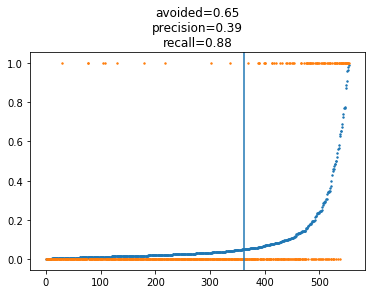

In [8]:
fig, ax = plt.subplots()

clf = SVC(kernel='rbf',probability=True)

clf.fit(tfidf_train,y_train)

plot_model_accuracy(clf,tfidf_test,y_test,ax,0.05)

In [9]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=50,random_state=1,
          alpha=.1, l1_ratio=.5)

W = nmf.fit_transform(data_term_doc)

## SVM classifier

clf = SVC(kernel='rbf',probability=True)

clf.fit(W[train.index,:],y_train)




SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

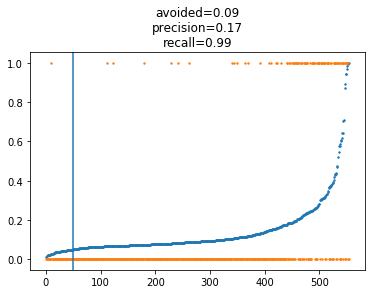

In [10]:
fig, ax = plt.subplots()
plot_model_accuracy(clf,W[test.index,:],y_test,ax,0.05)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


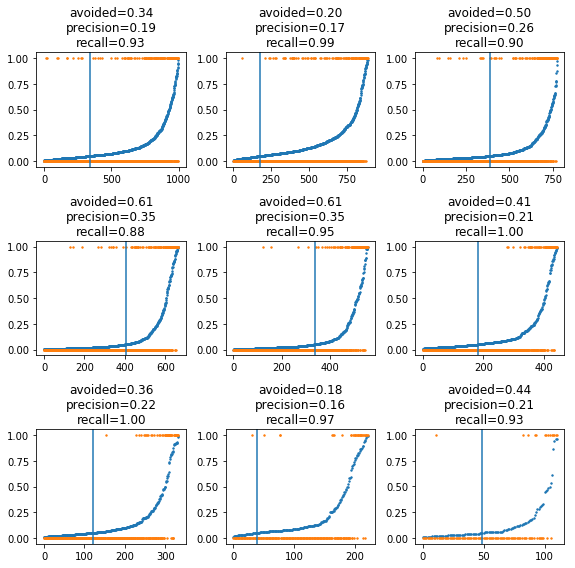

In [11]:
fig = plt.figure(figsize=(8,8))

for i in range(1,10):
    frac = i*0.1
    print(frac)
    train = df.sample(frac=frac)
    test = df[~df['id'].isin(train['id'])]
    y_train = np.array(train['relevant'])
    y_test = np.array(test['relevant'])
    
    clf = SVC(kernel='rbf',probability=True)
    clf.fit(data_term_doc[train.index,:],y_train)
    
    ax = fig.add_subplot(3,3,i)
    
    plot_model_accuracy(clf,data_term_doc[test.index,:],y_test,ax,0.05)
    
    #estimate
    #plot precision and recall
fig.tight_layout()
plt.show()

In [12]:
def precision_recall_plot(model,x_test,y_test, ax, frac):
    try:
        y_score = model.decision_function(x_test)
    except:
        y_score = model.predict_proba(x_test)[:,1]
    average_precision = average_precision_score(y_test, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))

    precision, recall, _ = precision_recall_curve(y_test, y_score)

    ax.step(recall, precision, color='b', alpha=0.2,
             where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('frac={0:0.2f}\nAP={1:0.2f}'.format(
        frac,average_precision
    ))
    

0.2
Average precision-recall score: 0.68
Average precision-recall score: 0.63
Average precision-recall score: 0.49
Average precision-recall score: 0.58
0.4
Average precision-recall score: 0.70
Average precision-recall score: 0.67
Average precision-recall score: 0.62
Average precision-recall score: 0.67
0.6000000000000001
Average precision-recall score: 0.71
Average precision-recall score: 0.66
Average precision-recall score: 0.56
Average precision-recall score: 0.64
0.8
Average precision-recall score: 0.86
Average precision-recall score: 0.85
Average precision-recall score: 0.64
Average precision-recall score: 0.72


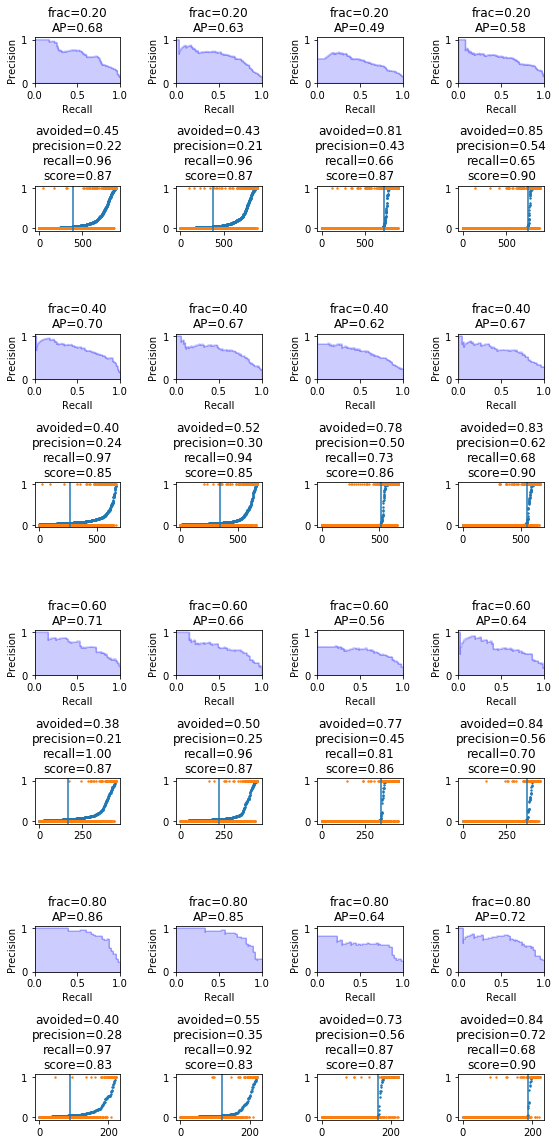

In [17]:
vec = TfidfVectorizer(
    ngram_range=(1,3),
    min_df=3, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,stop_words="english",tokenizer=tokenize
)

X = vec.fit_transform(df['content'])
y = np.array(df['relevant'])
fig, axs = plt.subplots(8,4,figsize=(8,16))



vec = TfidfVectorizer(
    ngram_range=(1,1),
    min_df=3, max_df=0.9, strip_accents='unicode', 
    use_idf=1, tokenizer=tokenize,
    smooth_idf=1, sublinear_tf=1,stop_words="english"
)

data_term_doc = vec.fit_transform(df['content'])
nmf = NMF(n_components=75,random_state=1,
          alpha=.01, l1_ratio=.5)

W = nmf.fit_transform(data_term_doc)

cvec = CountVectorizer(
    ngram_range=(1,1),
    min_df=3, max_df=0.9, 
    strip_accents='unicode',
    stop_words="english",
    tokenizer=tokenize
)

cX = cvec.fit_transform(df['content'])

for i in range(1,5):
    frac = i*0.2
    print(frac)
    train = df.sample(frac=frac)
    test = df[~df['id'].isin(train['id'])]
    
    
    
    clf = SVC(kernel='rbf',probability=True)
    clf.fit(X[train.index,:],y[train.index])
    
    ax = axs[(i-1)*2,0]
    
    precision_recall_plot(clf,X[test.index],y[test.index],ax,frac)
    
    ax = axs[(i-1)*2+1,0]
    plot_model_accuracy(clf,X[test.index],y[test.index],ax,0.05)
    
    clf = SVC(kernel='rbf',probability=True)
    clf.fit(W[train.index,:],y[train.index])
    
    ax = axs[(i-1)*2,1]
    
    precision_recall_plot(clf,W[test.index],y[test.index],ax,frac)
    
    ax = axs[(i-1)*2+1,1]
    plot_model_accuracy(clf,W[test.index],y[test.index],ax,0.05)
    
    
    clf = MultinomialNB(alpha=1)
    clf.fit(cX[train.index],y[train.index])
    
    ax = axs[(i-1)*2,2]  
    precision_recall_plot(clf,cX[test.index],y[test.index],ax,frac)
    
    ax = axs[(i-1)*2+1,2]
    plot_model_accuracy(clf,cX[test.index],y[test.index],ax,0.05)
    
    ### Neural Network
    clf = MLPClassifier(
        solver='lbfgs', 
        alpha=1e-5,
        hidden_layer_sizes=(10), 
        random_state=1
    )    
    clf.fit(cX[train.index],y[train.index])
    
    ax = axs[(i-1)*2,3]  
    precision_recall_plot(clf,cX[test.index],y[test.index],ax,frac)
    
    ax = axs[(i-1)*2+1,3]
    plot_model_accuracy(clf,cX[test.index],y[test.index],ax,0.05)
    
    #plot_model_accuracy(clf,y[test.index,y_test,ax,0.1)
    
    #estimate
    #plot precision and recall
fig.tight_layout()
plt.show()

In [ ]:
vec = CountVectorizer(ngram_range=(1,1),
               min_df=3, max_df=0.9, strip_accents='unicode',
               stop_words="english",tokenizer=tokenize)

X = vec.fit_transform(df['content'])

model = MultinomialNB(alpha=1)
model.fit(X[train.index],y[train.index])

fig, ax = plt.subplots()

plot_model_accuracy(model,X[test.index],y[test.index],ax,0.05)

In [ ]:
fig, ax = plt.subplots()

plot_model_accuracy(model,X[test.index],y[test.index],ax,0.05)

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA



vec = TfidfVectorizer(ngram_range=(1,1),
               min_df=3, max_df=0.9, strip_accents='unicode',
               stop_words="english",tokenizer=tokenize)

X = vec.fit_transform(df['content']).toarray()

model = LDA()
model.fit(X[train.index],y[train.index])

fig, ax = plt.subplots()

plot_model_accuracy(model,X[test.index],y[test.index],ax,0.05)

In [ ]:
y_prob = model.predict_proba(X[test.index])[:,1]
y_real = y[test.index]

for i, prob in enumerate(y_prob):
    r = y_real[i]
    ind = test.index[i]
    if prob < 0.05 and r==1:
        d = df.loc[ind]
        print('\n################\n')
        print('probability: {}'.format(prob))
        print(d['content'])



In [ ]:
vec = TfidfVectorizer(ngram_range=(1,1),
               min_df=3, max_df=0.9, strip_accents='unicode',
               stop_words="english",tokenizer=tokenize)

X = vec.fit_transform(df['content']).toarray()

nmf = NMF(n_components=75,random_state=1,
          alpha=.01, l1_ratio=.5)

W = nmf.fit_transform(data_term_doc)




In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50)
ts_X = tsne.fit_transform(X)

In [ ]:
fig = plt.figure(dpi=160)
colors = ["blue" if v==0 else "red" for v in y]
plt.scatter(ts_X[:,0],ts_X[:,1],c=colors,s=8)

In [ ]:
model = MultinomialNB(alpha=1)
model.fit(X[train.index],y[train.index])
y_prob = model.predict_proba(X[test.index])[:,1]
colors = ["blue" if v<0.05 else "red" for v in y_prob]
plt.scatter(ts_X[test.index,0],ts_X[test.index,1],c=colors,s=8)

In [ ]:
model = MultinomialNB(alpha=1)
model.fit(X[train.index],y[train.index])
y_prob = model.predict_proba(X[test.index])[:,1]
true_colors = ["blue" if v<0.05 else "red" for v in y_prob]

fig, axs = plt.subplots(1,2,dpi=150)

ax = axs[0]
ax.set_title("Estimated")

ax.scatter(ts_X[test.index,0],ts_X[test.index,1],c=true_colors,s=8)

ax = axs[1]

ax.set_title("True")
         

y_test = y[test.index]
colors = ["blue" if v==0 else "red" for v in y_test]
ax.scatter(
    ts_X[test.index,0],
    ts_X[test.index,1],
    c=colors,
    s=8,
    edgecolors=true_colors
)


perhaps we need a meta-level, where we run simulations on different queries, with different sized samples, predicting the precision and recall of given model as a function of:
- some characteristics of the dataset, text variations, relevant rarity etc.
- the size, absolute and proportional of the sample.

This way we can estimate the chance of reaching the required levell of precision and recall as the user rates documents

to do, below.
- run a simulation of the evaluation process - first with test data, then splitting sample into train and test. When can we stop, with what chance of what precision and recall?
- Try different strategies for allocating docs: in order they were really done, most relevant first, get to x% then remaining ones above threshold, boundary docs.


In [ ]:
vec = CountVectorizer(ngram_range=(1,1),
               min_df=3, max_df=0.9, strip_accents='unicode',
               stop_words="english",tokenizer=tokenize)

X = vec.fit_transform(df['content']).toarray()
model = MultinomialNB(alpha=1)
model.fit(X[train.index],y[train.index])



In [ ]:
fig, axs = plt.subplots(dpi=150)

model = MultinomialNB(alpha=1)
model = SVC(kernel='rbf',probability=True)
train = df.sample(frac=0)
partial = False
total_recall_1 = False
for i in range(120):

    s = i*10
    s_docs = list(range(s,s+10))
    sort_docs = df.sort_values('rated').copy().reset_index()
    if i > 0:
        s_docs = range(0,10)
        sort_docs = test.sort_values(
            'prob',ascending=False
        ).copy().reset_index(drop=True)
        #sort_docs = test.copy().reset_index(drop=True)
    #get train and test
    new_docs = sort_docs.loc[sort_docs.index.intersection(s_docs),:]
    
    #train = pd.concat([train,new_docs])
    train = df[df['id'].isin(list(train['id'])+list(new_docs['id']))]
    test = df[~df['id'].isin(train['id'])].copy()
    
    if test.index.size ==0:
        break
    if partial:
        model.partial_fit(
            X[train.index],
            y[train.index],
            classes=np.array([0,1])
        )
    else:
        model.fit(
            X[train.index],
            y[train.index]
        )
    
    y_prob = model.predict_proba(X[test.index])[:,1]
    y_predicted = np.where(y_prob > 0.05,1,0)
    y_test = y[test.index]
    
    test['prob'] = y_prob
    
    p = precision_score(y_test,y_predicted)
    r = recall_score(y_test,y_predicted)
    
    ys_seen = len(np.where(y[train.index] == 1)[0])
    total_ys = len(np.where(y == 1)[0])
    
    ys_predicted = len(np.where(y_predicted==1)[0])
    
    truefalse = zip(y_test,y_predicted)
    true_ys = np.array([1 if a==1 and b==1 else 0 for (a,b) in truefalse])
    n_true_ys = len(np.where(true_ys==1)[0])
    
    ns_seen = len(np.where(y[train.index] == 0)[0])
    total_ns = len(np.where(y == 0)[0])
    
    true_ns = np.array([1 if a==0 and b==0 else 0 for (a,b) in truefalse])
    n_true_ns = len(np.where(true_ns==1)[0])

    
    total_recall = (ys_seen+n_true_ys)/total_ys
    total_precision = (ns_seen+n_true_ns)/total_ns

    if total_recall==1 and total_precision==1 and total_recall_1 is False:
        plt.text(
            0,0.8,
            "Total recall after \n{} / {}documents".format(
                train.index.size,df.index.size
            )
        )
        total_recall_1=True
    
    plt.scatter(i,p,c="blue",s=5)
    plt.scatter(i,r,c="red",s=5)
    plt.scatter(i+0.2,total_recall,c="green",s=5)
    plt.scatter(i,total_precision,c="orange",s=5)


In [ ]:
model = MultinomialNB(alpha=1)
train = df.sample(frac=0)
for i in range(1000):
    s = i*10
    s_docs = list(range(s,s+10))
    sort_docs = df.sort_values('rated')
    #get train and test
    new_docs = sort_docs.loc[sort_docs.index.intersection(s_docs),:]
    
    train = pd.concat([train,new_docs])
    test = df[~df['id'].isin(train['id'])].copy()
    if test.index.size ==0:
        break
    
    model.fit(
        X[train.index],
        y[train.index]
    )
    
    y_prob = model.predict_proba(X[test.index])[:,1]
    y_predicted = np.where(y_prob > 0.05,1,0)
    y_test = y[test.index]
    
    p = precision_score(y_test,y_predicted)
    r = recall_score(y_test,y_predicted)
    
    ys_seen = len(np.where(y[train.index] == 1)[0])
    total_ys = len(np.where(y == 1)[0])
    ys_predicted = len(np.where(y_predicted==1)[0])
    
    total_recall = (ys_seen+ys_predicted)/total_ys
    
    plt.scatter(i,p,c="blue",s=5)
    plt.scatter(i,r,c="red",s=5)
    plt.scatter(i,total_recall,c="green",s=5)


In [ ]:
true_ys